## Calculate an accuracy value in HSLE Dataset

Data 
    
    - Collected from weight.csv file and applied two columns( weighted_value, IsHS) only. 
    - Manipulated four models(Random-Forest, LogisticRegression,AdaBoostClassifier and KNeighborsClassifier)
    - Selected the best model to predict a label value whether a HS Comment or No HS Comment.
    - Calculated a confusion matrix (Accuracy, Precision,Recall, F1-Score). 


In [1]:
import pandas as pd
import numpy as np
from glob import glob 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
import math 
import gspread 
import os 
from oauth2client.service_account import ServiceAccountCredentials


In [85]:
scope = ["https://spreadsheets.google.com/feeds", 'https://www.googleapis.com/auth/drive']

creds= ServiceAccountCredentials.from_json_keyfile_name('hs_data_sheet.json',scope)
client = gspread.authorize(creds)
HS_Accuracy =client.open('HS_Accuracy')

weighted_value_by_sentence = HS_Accuracy.get_worksheet(4)   #annotate_here

weighted_value_by_sentence_val=weighted_value_by_sentence.get_all_records()
weighted_value_by_sentence_list=[]
for index in range(len(weighted_value_by_sentence_val)):
    for key in weighted_value_by_sentence_val[index]:
        if key=='MsgUniSeg':
            MsgUniSeg_key=weighted_value_by_sentence_val[index][key]
        elif key=='Weighted_Value':
            Weighted_Value_key =weighted_value_by_sentence_val[index][key]
        elif key=='IsHS':
            IsHS=weighted_value_by_sentence_val[index][key]
        else:pass
    weighted_value_by_sentence_list.append([MsgUniSeg_key,Weighted_Value_key,IsHS])

#Create annotate_here dataframe 
weighted_val_new = pd.DataFrame(weighted_value_by_sentence_list, columns=['MsgUniSeg','Weighted_Value','IsHS'])


(15478, 3)

In [3]:
# Preprocessing Step
weighted_val_new['Weighted_Value'].isna().sum()

0

In [4]:
X=weighted_val_new[['Weighted_Value']]

In [5]:
 weighted_val_new['IsHS'].unique()

array([1, 0])

In [6]:
# y is a vector, hence we use dot to access 'label'
y = weighted_val_new[['IsHS']]

In [7]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.7,random_state=1)

In [8]:
## Apply RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
ytrain_pred = rf_model.predict_proba(X_train)
print('RF train roc-auc: {}'.format(roc_auc_score(y_train, ytrain_pred[:,1])))
ytest_pred = (rf_model.predict_proba(X_test))
print('RF test roc-auc: {}'.format(roc_auc_score(y_test, ytest_pred[:,1])))

RF train roc-auc: 0.8467565130067901
RF test roc-auc: 0.7220965098091275


In [9]:
log_classifier=LogisticRegression()
log_classifier.fit(X_train, y_train)
ytrain_pred = log_classifier.predict_proba(X_train)
print('Logistic train roc-auc: {}'.format(roc_auc_score(y_train, ytrain_pred[:,1])))
ytest_pred = log_classifier.predict_proba(X_test)
print('Logistic test roc-auc: {}'.format(roc_auc_score(y_test, ytest_pred[:,1])))

Logistic train roc-auc: 0.7500528101755095
Logistic test roc-auc: 0.7572086553501446


In [10]:
ada_classifier=AdaBoostClassifier()
ada_classifier.fit(X_train, y_train)
ytrain_pred = ada_classifier.predict_proba(X_train)
print('Adaboost train roc-auc: {}'.format(roc_auc_score(y_train, ytrain_pred[:,1])))
ytest_pred = ada_classifier.predict_proba(X_test)
print('Adaboost test roc-auc: {}'.format(roc_auc_score(y_test, ytest_pred[:,1])))

Adaboost train roc-auc: 0.7638214152368931
Adaboost test roc-auc: 0.7683312939736924


In [11]:
knn_classifier=KNeighborsClassifier()
knn_classifier.fit(X_train, y_train)
ytrain_pred = knn_classifier.predict_proba(X_train)
print('Adaboost train roc-auc: {}'.format(roc_auc_score(y_train, ytrain_pred[:,1])))
ytest_pred = knn_classifier.predict_proba(X_test)
print('Adaboost test roc-auc: {}'.format(roc_auc_score(y_test, ytest_pred[:,1])))

Adaboost train roc-auc: 0.760738985064508
Adaboost test roc-auc: 0.7135798265005165


In [12]:
pred=[]
for model in [rf_model,log_classifier,ada_classifier,knn_classifier]:
    pred.append(pd.Series(model.predict_proba(X_test)[:,1]))
final_prediction=pd.concat(pred,axis=1).mean(axis=1)
print(' test roc-auc: {}'.format(roc_auc_score(y_test,final_prediction)))

 test roc-auc: 0.7616289673721697


In [13]:
pd.concat(pred,axis=1).mean(axis=1)

0       0.176849
1       0.336051
2       0.265810
3       0.256701
4       0.161961
          ...   
4639    0.562719
4640    0.150045
4641    0.708163
4642    0.341612
4643    0.301000
Length: 4644, dtype: float64

In [14]:
#### Calculate the ROc Curve
fpr, tpr, thresholds = roc_curve(y_test, final_prediction)
# thresholds

In [52]:
accuracy_ls = []
for thres in thresholds:
    y_pred = np.where(final_prediction>thres,1,0)
    accuracy_ls.append(accuracy_score(y_test, y_pred, normalize=True))
    
accuracy_ls = pd.concat([pd.Series(thresholds), pd.Series(accuracy_ls)],
                        axis=1)
accuracy_ls.columns = ['thresholds', 'accuracy']
accuracy_ls.sort_values(by='accuracy', ascending=False, inplace=True)
accuracy_ls.head()

,thresholds,accuracy
78,0.584813,0.806848
75,0.590433,0.806417
76,0.586876,0.806417
79,0.583690,0.806417
77,0.585824,0.806202


In [75]:
# print the first predicted probabilities of class membership
y_pred_class =(rf_model.predict_proba(X_test)[:,1] >=0.3).astype(bool)

In [76]:
# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test, y_pred_class)
print(confusion)

#[row, column]
TP = confusion[1, 1]  
TN = confusion[0, 0] 
FP = confusion[0, 1] 
FN = confusion[1, 0]  


[[3138  572]
 [ 481  453]]


In [77]:
# use float to perform true division, not integer division
Accuracy =(TP + TN) / float(TP + TN + FP + FN)

print("Accuracy  :  ",Accuracy)
print("Accuracy  :  ",metrics.accuracy_score(y_test, y_pred_class))

Accuracy  :   0.7732558139534884
Accuracy  :   0.7732558139534884


In [78]:
classification_error = (FP + FN) / float(TP + TN + FP + FN)

print(classification_error)
print(1 - metrics.accuracy_score(y_test, y_pred_class))

0.22674418604651161
0.2267441860465116


In [79]:
sensitivity_recall = TP / float(FN + TP)   # True Positive Rate


print("Recall           : ",sensitivity_recall)

print("Metric Recall    : ",metrics.recall_score(y_test, y_pred_class))

Recall           :  0.48501070663811563
Metric Recall    :  0.48501070663811563


In [80]:
specificity = TN / (TN + FP)  

print(specificity)

0.845822102425876


In [81]:
false_positive_rate = FP / float(TN + FP)   # False Positive Rate

print(false_positive_rate)
print(1 - specificity)

0.15417789757412398
0.15417789757412403


In [82]:
precision = TP / float(TP + FP)

print(precision)
print(metrics.precision_score(y_test, y_pred_class))

0.4419512195121951
0.4419512195121951


In [83]:
F1=2*((precision*sensitivity_recall)/(precision+sensitivity_recall))


In [84]:
print("Accuracy     :   ",Accuracy)
print("Precision    :   ",precision)
print("Recall       :   ",sensitivity_recall)
print("F1 Score     :   ",F1)

Accuracy     :    0.7732558139534884
Precision    :    0.4419512195121951
Recall       :    0.48501070663811563
F1 Score     :    0.46248085758039814


In [63]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

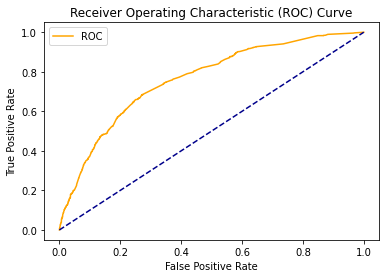

In [64]:
plot_roc_curve(fpr,tpr)